In [225]:
import pandas as pd
from torch import nn, optim
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report

In [227]:
class PathwayScores(Dataset):

    def __init__(self, csv_file):
        """Initializes instance of class PathwayScores.

        Args:
            csv_file (str): Path to the csv file with the data.

        """
        self.df = pd.read_csv(csv_file, sep='\t')
        self.df = self.df[self.df["PAM50"] != "NC"]

        # Grouping variable names
        self.features = ['Cell_Cycle', 'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53', 'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2']
        self.target = "PAM50"
        
        self.df['PAM50'] = self.df['PAM50'].astype('category')
        self.df['PAM50'] = self.df['PAM50'].cat.codes.values

        # Save target and predictors
        self.X = self.df.loc[:, self.features].values
        self.y = self.df.loc[:, self.target].values

        self.transform = transforms.Compose([transforms.ToTensor()]) 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.transform(self.X.iloc[idx].values), self.transform(self.y[idx])]


In [265]:
class Net(nn.Module):

  def __init__(self, n_features):

    super(Net, self).__init__()

    self.fc1 = nn.Linear(n_features, 120)

    self.fc2 = nn.Linear(120, 84)

    self.fc3 = nn.Linear(84, 5)

  def forward(self, x):

    x = F.relu(self.fc1(x))

    x = F.relu(self.fc2(x))

    return self.fc3(x)


In [266]:
csv_file = "data/pathwayscores_clinicalinformation_METABRIC.tsv"
dataset = PathwayScores(csv_file)


array([4, 2, 3, ..., 3, 3, 3], dtype=int8)

In [267]:
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.2, random_state=47)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1588, 14]) torch.Size([1588])
torch.Size([398, 14]) torch.Size([398])


In [268]:
model = Net(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [269]:
y_train

tensor([3, 1, 2,  ..., 4, 2, 2])

In [270]:
epochs = 80
losses = []
for i in range(epochs):
    i += 1
    
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    losses.append(loss)
    
    if i % 10 == 0:

        print(f'epoch: {i} -> loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 10 -> loss: 1.5951164960861206
epoch: 20 -> loss: 1.4990801811218262
epoch: 30 -> loss: 1.3838818073272705
epoch: 40 -> loss: 1.2435766458511353
epoch: 50 -> loss: 1.11240816116333
epoch: 60 -> loss: 1.0097651481628418
epoch: 70 -> loss: 0.9338728785514832
epoch: 80 -> loss: 0.8844150900840759


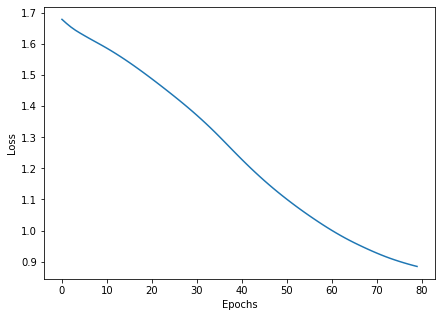

In [271]:
plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [272]:
with torch.no_grad():
    
    correct = 0
    
    for i, X in enumerate(X_test):
        
        y_pred = model(X)
        
        if y_pred.argmax().item() == y_test[i]:
            correct += 1
            
print(f'{correct} out of {y_test.shape[0]} is correct : {correct / y_test.shape[0] * 100}%')

260 out of 398 is correct : 65.32663316582915%


In [273]:
def calculate_accuracy(y_true, y_pred):

  predicted = y_pred.ge(.5).view(-1)

  return (y_true == predicted).sum().float() / len(y_true)

In [125]:
def round_tensor(t, decimal_places=3):

  return round(t.item(), decimal_places)

for epoch in range(1000):

    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)

    train_loss = criterion(y_pred, y_train)

    if epoch % 100 == 0:

      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)

      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)

      print(

f'''epoch {epoch}

Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}

Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}

''')

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

epoch 0

Train set - loss: 4.507, accuracy: 0.124

Test  set - loss: 4.287, accuracy: 0.105


epoch 100

Train set - loss: 4.176, accuracy: 0.124

Test  set - loss: 3.981, accuracy: 0.105


epoch 200

Train set - loss: 3.622, accuracy: 0.124

Test  set - loss: 3.474, accuracy: 0.105


epoch 300

Train set - loss: 3.298, accuracy: 0.124

Test  set - loss: 3.183, accuracy: 0.105


epoch 400

Train set - loss: 3.226, accuracy: 0.124

Test  set - loss: 3.119, accuracy: 0.105


epoch 500

Train set - loss: 3.205, accuracy: 0.124

Test  set - loss: 3.102, accuracy: 0.105


epoch 600

Train set - loss: 3.197, accuracy: 0.124

Test  set - loss: 3.095, accuracy: 0.105


epoch 700

Train set - loss: 3.193, accuracy: 0.124

Test  set - loss: 3.091, accuracy: 0.105


epoch 800

Train set - loss: 3.191, accuracy: 0.124

Test  set - loss: 3.089, accuracy: 0.105


epoch 900

Train set - loss: 3.19, accuracy: 0.124

Test  set - loss: 3.088, accuracy: 0.105




In [126]:
outputs = net(X_test)

In [128]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,